In [1]:
import pandas as pd
import numpy as np
import random, json, os, math
from sklearn.cluster import KMeans

def convert_txt_to_json_vrp4(
    path_txt,
    path_json_out,
    n_depots=3,
    n_vendors=None,
    n_markets=None,
    commodities=None,
    depot_capacity_factor=1.2,
    balance_factor=0.8,
    magnitude_factor=5.0,
    depot_selection="kmeans",
    seed=42
):
    if commodities is None:
        commodities = ["food", "drink", "electronics", "household"]

    rng = random.Random(seed)
    np.random.seed(seed)

    # Đọc file Li & Lim: bỏ dòng meta đầu, đọc phần node
    df = pd.read_csv(path_txt, sep=r"\s+", header=None, skiprows=1,
                     names=["id","x","y","demand","ready","due","service","pickup","delivery"])
    # Bảo đảm kiểu số Python (tránh np.generic len lỏi)
    df = df.astype({
        "id": "int64", "x": "float64", "y": "float64",
        "demand": "float64", "ready": "float64", "due":"float64",
        "service":"float64", "pickup":"float64", "delivery":"float64"
    })
    df = df.sort_values("id").reset_index(drop=True)

    coords = df[["x","y"]].to_numpy(dtype=float)
    n_total = int(len(df))

    # Mặc định 40/60 trên phần còn lại sau khi lấy depot
    remaining = n_total - int(n_depots)
    if n_vendors is None or n_markets is None:
        n_vendors = int(round(remaining * 0.4))
        n_markets = int(remaining - n_vendors)
    # Nếu vì làm tròn bị lệch, hiệu chỉnh lại
    if n_vendors + n_markets != remaining:
        n_markets = remaining - n_vendors
    print(f"➡️ Default/Current split: {n_vendors} vendors / {n_markets} markets (remaining={remaining}, total={n_total})")

    # --- Chọn depot ---
    if depot_selection == "kmeans":
        kmeans = KMeans(n_clusters=int(n_depots), random_state=seed, n_init=10)
        kmeans.fit(coords)
        centers = kmeans.cluster_centers_
        depot_indices = []
        for c in centers:
            d = np.linalg.norm(coords - c, axis=1)
            for idx in depot_indices: d[idx] = np.inf
            depot_indices.append(int(np.argmin(d)))
    else:
        depot_indices = rng.sample(range(n_total), int(n_depots))

    depot_ids = list(map(int, df.loc[depot_indices, "id"].tolist()))

    # Chia vendor/market ngẫu nhiên (đơn giản). Có thể thay bằng chia theo cụm nếu muốn.
    remaining_idx = [i for i in range(n_total) if i not in depot_indices]
    rng.shuffle(remaining_idx)
    vendor_idx = remaining_idx[:n_vendors]
    market_idx = remaining_idx[n_vendors:n_vendors + n_markets]

    vendor_ids = list(map(int, df.loc[vendor_idx, "id"].tolist()))
    market_ids = list(map(int, df.loc[market_idx, "id"].tolist()))

    # --- Sinh hàng hoá (Python float thuần) ---
    def rnd(a,b): return float(round(rng.uniform(a,b), 1))
    vendor_data = [{c: rnd(3,12) for c in commodities} for _ in range(n_vendors)]
    market_data = [{c: rnd(2,10) for c in commodities} for _ in range(n_markets)]

    total_vendor = {c: float(round(sum(v[c] for v in vendor_data), 1)) for c in commodities}
    total_market = {c: float(round(sum(m[c] for m in market_data), 1)) for c in commodities}

    # Giới hạn cầu ≤ cung*balance_factor, rồi khuếch đại magnitude
    for c in commodities:
        cap = total_vendor[c] * float(balance_factor)
        cur = total_market[c]
        if cur > 0 and cur > cap:
            scale = float(cap/cur)
            for m in market_data: m[c] = float(round(m[c]*scale, 1))

    for v in vendor_data:
        for c in commodities: v[c] = float(round(v[c]*magnitude_factor, 1))
    for m in market_data:
        for c in commodities: m[c] = float(round(m[c]*magnitude_factor, 1))

    total_vendor = {c: float(round(sum(v[c] for v in vendor_data), 1)) for c in commodities}
    total_market = {c: float(round(sum(m[c] for m in market_data), 1)) for c in commodities}

    depot_capacity_total = {c: float(round(total_market[c]*1.2, 1)) for c in commodities}
    depot_capacity = {c: float(round((depot_capacity_total[c]/int(n_depots))*float(depot_capacity_factor), 1))
                      for c in commodities}

    # --- Build node JSON (ép kiểu Python int/float) ---
    node_data = []
    v_idx = m_idx = 0
    id_set = set(depot_ids) | set(vendor_ids) | set(market_ids)

    for _, row in df.iterrows():
        nid = int(row["id"])
        if nid not in id_set: 
            continue

        x = float(row["x"]); y = float(row["y"])

        if nid in depot_ids:
            node_data.append({
                "id": int(nid),
                "type": "depot",
                "coord_x": x,
                "coord_y": y,
                "storage_capacity_dict": {k: float(v) for k,v in depot_capacity.items()}
            })
        elif nid in vendor_ids:
            v = vendor_data[v_idx]; v_idx += 1
            node_data.append({
                "id": int(nid),
                "type": "vendor",
                "coord_x": x,
                "coord_y": y,
                "collected_goods_dict": {k: float(vv) for k,vv in v.items()},
                "total_goods": float(round(sum(v.values()), 1))
            })
        else:  # market
            m = market_data[m_idx]; m_idx += 1
            node_data.append({
                "id": int(nid),
                "type": "market",
                "coord_x": x,
                "coord_y": y,
                "order_dict": {k: float(vv) for k,vv in m.items()},
                "total_order": float(round(sum(m.values()), 1))
            })

    data = {
        "meta": {
            "total_nodes": int(len(node_data)),
            "n_depots": int(n_depots),
            "n_vendors": int(n_vendors),
            "n_markets": int(n_markets),
            "commodities": list(commodities),
            "depot_capacity_factor": float(depot_capacity_factor),
            "balance_factor": float(balance_factor),
            "magnitude_factor": float(magnitude_factor),
            "depot_selection": str(depot_selection)
        },
        "nodes": node_data
    }

    os.makedirs(os.path.dirname(path_json_out), exist_ok=True)
    with open(path_json_out, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)

    print(f"✅ Saved JSON to {path_json_out}")
    print(f"🏢 Depots: {depot_ids}")
    print(f"🏬 Vendors: {len(vendor_ids)}, 🏪 Markets: {len(market_ids)}")
    print("📦 Total vendor goods:", total_vendor)
    print("🛒 Total market demand:", total_market)
    print("🏭 Depot capacity each depot:", depot_capacity)



In [2]:
convert_txt_to_json_vrp4(
    path_txt=r"C:\Users\thaip\Desktop\VRP4\data\Li and Lim\LC1_10_1.txt",
    path_json_out=r"C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_standard.json",
    n_depots=10,
    depot_selection="kmeans"
)


➡️ Default/Current split: 418 vendors / 627 markets (remaining=1045, total=1055)
✅ Saved JSON to C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_standard.json
🏢 Depots: [364, 243, 132, 338, 868, 623, 811, 506, 497, 218]
🏬 Vendors: 418, 🏪 Markets: 627
📦 Total vendor goods: {'food': 15377.5, 'drink': 15881.5, 'electronics': 16022.5, 'household': 15493.0}
🛒 Total market demand: {'food': 12304.0, 'drink': 12703.0, 'electronics': 12819.0, 'household': 12392.5}
🏭 Depot capacity each depot: {'food': 1771.8, 'drink': 1829.2, 'electronics': 1845.9, 'household': 1784.5}


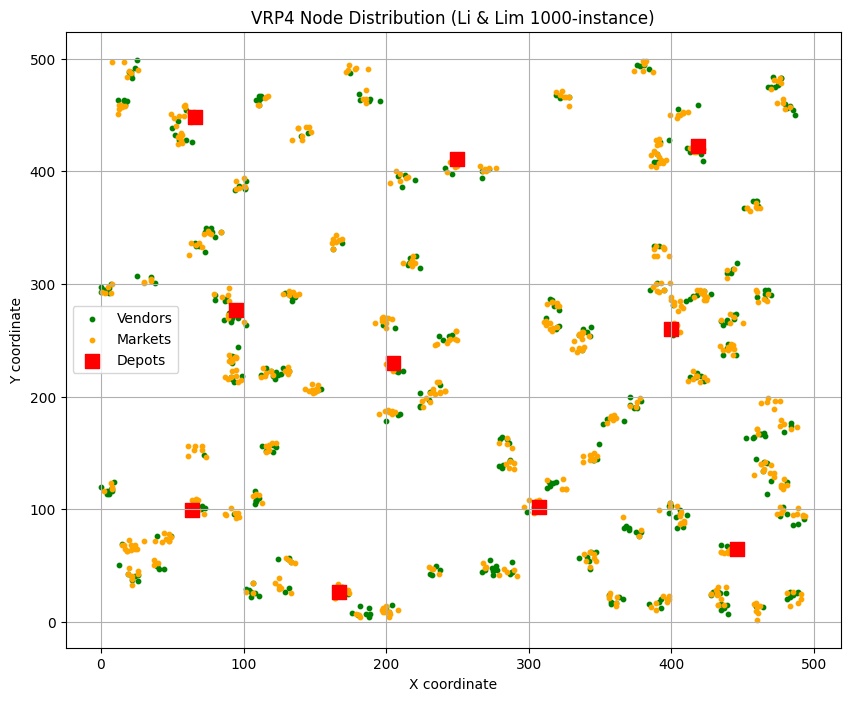

In [3]:
import json
import matplotlib.pyplot as plt

path_json = r"C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_standard.json"
with open(path_json, "r", encoding="utf-8") as f:
    data = json.load(f)

depots = [n for n in data["nodes"] if n["type"] == "depot"]
vendors = [n for n in data["nodes"] if n["type"] == "vendor"]
markets = [n for n in data["nodes"] if n["type"] == "market"]

x_d, y_d = [n["coord_x"] for n in depots], [n["coord_y"] for n in depots]
x_v, y_v = [n["coord_x"] for n in vendors], [n["coord_y"] for n in vendors]
x_m, y_m = [n["coord_x"] for n in markets], [n["coord_y"] for n in markets]

# --- Vẽ ---
plt.figure(figsize=(10, 8))
plt.scatter(x_v, y_v, c="green", s=10, label="Vendors")
plt.scatter(x_m, y_m, c="orange", s=10, label="Markets")
plt.scatter(x_d, y_d, c="red", s=100, marker="s", label="Depots")

plt.title("VRP4 Node Distribution (Li & Lim 1000-instance)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import xml.etree.ElementTree as ET
import json
import os
import math
import random

def extract_edges_with_forbidden(
    node_json_path, 
    edge_json_out, 
    forbid_ratio=0.02,   
    distance_metric="manhattan", 
    seed=42
):
    """
    Sinh danh sách cạnh từ file node JSON (VRP4 chuẩn)
    và sinh ngẫu nhiên một số cạnh bị cấm (forbidden edges).
    """
    rng = random.Random(seed)

    with open(node_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    nodes = data["nodes"]
    n = len(nodes)
    ids = [n["id"] for n in nodes]
    print(f"📍 Có {n} node trong file: {node_json_path}")

    def dist(a,b):
        if distance_metric == "manhattan":
            return abs(a["coord_x"]-b["coord_x"]) + abs(a["coord_y"]-b["coord_y"])
        else:
            return math.sqrt((a["coord_x"]-b["coord_x"])**2 + (a["coord_y"]-b["coord_y"])**2)

    # --- Sinh cạnh đầy đủ ---
    edges = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            d = round(dist(nodes[i], nodes[j]), 2)
            edges.append({"from": i, "to": j, "distance": d})

    print(f"✅ Tạo {len(edges)} cạnh đầy đủ (đồ thị có hướng).")

    total_possible = n*(n-1)//2
    n_forbidden = int(total_possible * forbid_ratio)
    forbidden = set()

    while len(forbidden) < n_forbidden:
        a, b = rng.sample(range(n), 2)
        if a != b and (a,b) not in forbidden and (b,a) not in forbidden:
            forbidden.add((a,b))
            forbidden.add((b,a))  # đảm bảo đối xứng

    forbidden_edges = [{"from": a, "to": b} for a,b in forbidden]

    print(f"🚫 Sinh ngẫu nhiên {len(forbidden)//2} cạnh bị cấm ({forbid_ratio*100:.1f}% tổng số cặp).")

    filtered_edges = [e for e in edges if (e["from"], e["to"]) not in forbidden]
    print(f"✅ Còn lại {len(filtered_edges)} cạnh hợp lệ sau khi loại cấm.")

    os.makedirs(os.path.dirname(edge_json_out), exist_ok=True)
    out = {
        "type": "edge_list",
        "unit": distance_metric,
        "n_nodes": n,
        "edges": filtered_edges,
        "forbidden_edges": forbidden_edges
    }
    with open(edge_json_out, "w", encoding="utf-8") as f:
        json.dump(out, f, indent=2)

    print(f"💾 Đã lưu danh sách cạnh + cạnh cấm vào: {edge_json_out}")
    return n, filtered_edges, forbidden_edges


def build_graph_matrix_with_forbidden(edge_json_path, out_json_path):
    """
    Tạo ma trận kề và ma trận khoảng cách từ edge list có forbidden edges.
    """
    with open(edge_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    edges = data["edges"]
    forbidden = data.get("forbidden_edges", [])
    n = data["n_nodes"]

    print(f"📦 Đọc {len(edges)} cạnh hợp lệ và {len(forbidden)//2} cạnh cấm từ {edge_json_path}")

    adjacency = [[0]*n for _ in range(n)]
    distance = [[float("inf")]*n for _ in range(n)]

    for e in edges:
        i, j, d = e["from"], e["to"], e["distance"]
        adjacency[i][j] = 1
        distance[i][j] = d

    for i in range(n):
        adjacency[i][i] = 0
        distance[i][i] = 0.0

    total_possible = n*(n-1)
    actual_edges = sum(1 for i in range(n) for j in range(n) if i!=j and distance[i][j]!=float("inf"))
    density = (actual_edges/total_possible)*100

    os.makedirs(os.path.dirname(out_json_path), exist_ok=True)
    out = {
        "type": "graph_with_adjacency",
        "unit": "manhattan_distance",
        "n_nodes": n,
        "adjacency_matrix": adjacency,
        "distance_matrix": distance,
        "forbidden_edges": forbidden
    }

    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(out, f, indent=2)

    print(f"✅ Lưu ma trận có {actual_edges} cạnh hợp lệ ({density:.2f}% density).")
    print(f"💾 File: {out_json_path}")


# ===============================
# MAIN
# ===============================
if __name__ == "__main__":
    node_json = r"C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_standard.json"
    edge_json = r"C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_edges.json"
    matrix_json = r"C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_graph_matrix.json"

    print(f"--- SINH CẠNH + CẠNH CẤM CHO FILE: {os.path.basename(node_json)} ---")

    n, edges, forbidden = extract_edges_with_forbidden(
        node_json_path=node_json,
        edge_json_out=edge_json,
        forbid_ratio=0.02,        # 2% cạnh bị cấm
        distance_metric="manhattan",
        seed=42
    )

    build_graph_matrix_with_forbidden(edge_json_path=edge_json, out_json_path=matrix_json)

    print("\n🎯 Hoàn tất pipeline sinh cạnh + cạnh cấm + ma trận.")


--- SINH CẠNH + CẠNH CẤM CHO FILE: LC1_10_1_standard.json ---
📍 Có 1055 node trong file: C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_standard.json
✅ Tạo 1111970 cạnh đầy đủ (đồ thị có hướng).
🚫 Sinh ngẫu nhiên 5560 cạnh bị cấm (2.0% tổng số cặp).
✅ Còn lại 1100850 cạnh hợp lệ sau khi loại cấm.
💾 Đã lưu danh sách cạnh + cạnh cấm vào: C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_edges.json
📦 Đọc 1100850 cạnh hợp lệ và 5560 cạnh cấm từ C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_edges.json
✅ Lưu ma trận có 1100850 cạnh hợp lệ (99.00% density).
💾 File: C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_graph_matrix.json

🎯 Hoàn tất pipeline sinh cạnh + cạnh cấm + ma trận.


In [5]:
import json
import random
import os
from pathlib import Path # Sử dụng Pathlib cho đường dẫn

def generate_vehicle_data_from_nodes(
    path_nodes_json,
    path_json_out="osaba_100_vehicles",
    vehicles_per_depot=None,
    vehicle_types=None,
    capacity_scales=None,
    vehicle_costs=None,
    ratio_to_vendor=0.5,
    seed=42,
    equal_per_commodity=True
):
    random.seed(seed)

    # --- 1. Đọc dữ liệu node ---
    try:
        with open(path_nodes_json, "r", encoding="utf-8") as f:
            node_data = json.load(f)
    except FileNotFoundError:
        print(f"LỖI: Không tìm thấy tệp node tại: {path_nodes_json}")
        return
    except json.JSONDecodeError:
         print(f"LỖI: Tệp JSON node không hợp lệ: {path_nodes_json}")
         return


    if "meta" not in node_data or "nodes" not in node_data:
        print(f"LỖI: Tệp {path_nodes_json} có vẻ không đúng định dạng.")
        return

    meta = node_data["meta"]
    
    # Lấy thông tin depot và commodities từ meta hoặc nodes
    try:
        commodities = meta["commodities"]
        # Đếm số depot thực tế từ list nodes thay vì chỉ dựa vào meta["n_depots"]
        actual_depots = [n for n in node_data["nodes"] if n.get("type") == "depot"]
        n_depots = len(actual_depots)
        if n_depots == 0:
             print("LỖI: Không tìm thấy node depot nào trong file.")
             return
    except KeyError:
        print("LỖI: Thiếu thông tin 'commodities' hoặc 'nodes' trong file JSON.")
        return
        
    K = len(commodities) 

    # --- 2. Tính tổng cung từ vendor ---
    total_vendor = {c: 0.0 for c in commodities}
    vendor_count = 0
    for n in node_data["nodes"]:
        if n.get("type") == "vendor":
            vendor_count += 1
            goods_dict = n.get("collected_goods_dict", {})
            for c in commodities:
                total_vendor[c] += float(goods_dict.get(c, 0.0))

    if vendor_count == 0:
        print("CẢNH BÁO: Không tìm thấy 'vendor' nào.")

    # --- 3. Tham số mặc định ---
    if vehicle_types is None:
        vehicle_types = ["type_1", "type_2", "type_3"]
    if capacity_scales is None:
        capacity_scales = {"type_1": 1.0, "type_2": 1.5, "type_3": 2.3}
    if vehicle_costs is None:
        vehicle_costs = {"type_1": 1.0, "type_2": 1.3, "type_3": 1.8}
    if vehicles_per_depot is None:
        # Mặc định: mỗi depot có số xe bằng số loại xe
        vehicles_per_depot = [len(vehicle_types)] * n_depots
        print(f"vehicles_per_depot không được cung cấp, mặc định là: {vehicles_per_depot}")


    if len(vehicles_per_depot) != n_depots:
         print(f"⚠️ Lỗi: Độ dài 'vehicles_per_depot' ({len(vehicles_per_depot)}) "
               f"khác với số depot tìm thấy ({n_depots})")
         # Cố gắng sửa lỗi bằng cách lặp lại hoặc cắt bớt
         if len(vehicles_per_depot) > n_depots:
              vehicles_per_depot = vehicles_per_depot[:n_depots]
         elif len(vehicles_per_depot) > 0: # Ít hơn n_depots nhưng > 0
              vehicles_per_depot = (vehicles_per_depot * (n_depots // len(vehicles_per_depot) + 1))[:n_depots]
         else: # List rỗng
              vehicles_per_depot = [len(vehicle_types)] * n_depots # Quay về mặc định
         print(f"Đã tự động điều chỉnh vehicles_per_depot thành: {vehicles_per_depot}")


    total_vehicle = sum(vehicles_per_depot)
    if total_vehicle == 0:
        print("CẢNH BÁO: Tổng số xe là 0.")
        
    # --- 4. Chuẩn bị tạo danh sách xe (để biết tổng scale) ---
    type_choices = []
    
    # (*** LOGIC MỚI ***)
    # Kiểm tra điều kiện đặc biệt: 3 loại xe và mỗi depot có 3 xe
    is_special_case = (len(vehicle_types) == 3 and all(n == 3 for n in vehicles_per_depot))

    if is_special_case:
        print("Áp dụng logic gán đặc biệt: Mỗi depot nhận 1 xe mỗi loại.")
        shuffled_types = vehicle_types[:] # Tạo bản sao
        for depot_id, n_vehicle in enumerate(vehicles_per_depot):
             # n_vehicle chắc chắn là 3 ở đây
             random.shuffle(shuffled_types) # Xáo trộn thứ tự loại xe cho mỗi depot
             type_choices.extend(shuffled_types)
    else:
        print("Áp dụng logic gán ngẫu nhiên loại xe.")
        # Logic cũ: Gán loại xe ngẫu nhiên cho từng slot xe
        for depot_id, n_vehicle in enumerate(vehicles_per_depot):
            for _ in range(n_vehicle):
                if not vehicle_types: # Xử lý trường hợp list rỗng
                     print("Lỗi: vehicle_types rỗng!")
                     return
                type_choices.append(random.choice(vehicle_types))
                
    # Đảm bảo số lượng type_choices khớp tổng số xe
    if len(type_choices) != total_vehicle:
        print(f"Lỗi logic: Số lượng type_choices ({len(type_choices)}) không khớp total_vehicle ({total_vehicle})")
        # Fallback về random nếu có lỗi
        type_choices = [random.choice(vehicle_types) for _ in range(total_vehicle)] if vehicle_types else []


    scales_list = [capacity_scales.get(t, 1.0) for t in type_choices]
    sum_scales = sum(scales_list)
    scale_mean = sum_scales / total_vehicle if total_vehicle > 0 else 1.0

    # --- 5. Mục tiêu capacity ---
    total_vendor_all = sum(total_vendor.values())
    target_total_capacity_all = ratio_to_vendor * total_vendor_all

    vehicles = []
    v_global_idx = 0 # ID xe toàn cục

    if total_vehicle > 0: # Chỉ tạo xe nếu có
        if equal_per_commodity:
            if K == 0 or sum_scales == 0:
                base_scalar = 0.0
            else:
                base_scalar = target_total_capacity_all / (K * sum_scales)

            depot_idx_counter = 0
            vehicles_assigned_to_depot = 0
            for i in range(total_vehicle):
                type_name = type_choices[i]
                scale = capacity_scales.get(type_name, 1.0) # Lấy scale đúng
                per_commodity_cap = round(base_scalar * scale, 1)
                cap_dict = {c: per_commodity_cap for c in commodities}
                cap_vec = [per_commodity_cap] * K
                
                vehicles.append({
                    "vehicle_id": f"D{depot_idx_counter}_V{v_global_idx}",
                    "depot_id": depot_idx_counter,
                    "vehicle_type": type_name,
                    "capacity_dict": cap_dict,
                    "capacity_vec": cap_vec,
                    "total_capacity": round(per_commodity_cap * K, 1),
                    "cost_per_km": vehicle_costs.get(type_name, 1.0)
                })
                v_global_idx += 1
                vehicles_assigned_to_depot += 1
                # Chuyển sang depot tiếp theo nếu đã đủ xe cho depot hiện tại
                if vehicles_assigned_to_depot >= vehicles_per_depot[depot_idx_counter]:
                    depot_idx_counter += 1
                    vehicles_assigned_to_depot = 0
                
        else: # Logic capacity theo tỉ lệ cung vendor
            target_capacity = {c: total_vendor[c] * ratio_to_vendor for c in commodities}
            base_capacity = {
                c: (target_capacity[c] / sum_scales) if sum_scales > 0 else 0.0
                for c in commodities
            }
            
            depot_idx_counter = 0
            vehicles_assigned_to_depot = 0
            for i in range(total_vehicle):
                type_name = type_choices[i]
                scale = capacity_scales.get(type_name, 1.0) # Lấy scale đúng
                cap_dict = {c: round(base_capacity[c] * scale, 1) for c in commodities}
                cap_vec = [cap_dict.get(c, 0.0) for c in commodities] # Đảm bảo đúng thứ tự

                vehicles.append({
                    "vehicle_id": f"D{depot_idx_counter}_V{v_global_idx}",
                    "depot_id": depot_idx_counter,
                    "vehicle_type": type_name,
                    "capacity_dict": cap_dict,
                    "capacity_vec": cap_vec,
                    "total_capacity": round(sum(cap_vec), 1),
                    "cost_per_km": vehicle_costs.get(type_name, 1.0)
                })
                v_global_idx += 1
                vehicles_assigned_to_depot += 1
                if vehicles_assigned_to_depot >= vehicles_per_depot[depot_idx_counter]:
                    depot_idx_counter += 1
                    vehicles_assigned_to_depot = 0

    data = {
        "meta": {
            "n_depots": n_depots,
            "n_vehicles": len(vehicles),
            "vehicle_types_defined": vehicle_types,
            "vehicle_costs": vehicle_costs,
            "capacity_scales": capacity_scales,
            "ratio_to_vendor_target": ratio_to_vendor,
            "capacity_mode": "equal_per_commodity" if equal_per_commodity else "proportional_by_vendor"
        },
        "vehicles": vehicles
    }
    
    # Tạo thư mục nếu chưa tồn tại
    output_path = Path(path_json_out) # Chuyển sang Pathlib
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)

    # --- 6. Thống kê ---
    if not commodities:
        print(f"✅ Vehicle JSON (không có hàng hóa) saved to {output_path}")
        return

    total_cap = {c: sum(v["capacity_dict"].get(c, 0.0) for v in vehicles) for c in commodities}
    total_vendor_all_safe = sum(total_vendor.values()) if sum(total_vendor.values()) > 0 else 1.0 # Tránh chia cho 0
    
    ratio_real_by_c = {
        k: (total_cap[k] / total_vendor[k] * 100) if total_vendor.get(k, 0.0) > 0 else 0.0
        for k in commodities
    }
    ratio_real_total = (sum(total_cap.values()) / total_vendor_all_safe * 100)

    print(f"✅ Vehicle JSON saved to {output_path}")
    print(f"📦 Tổng xe mỗi depot: {vehicles_per_depot} (Tổng: {total_vehicle} xe)")
    print("📦 Tổng cung vendor:", {k: round(v, 1) for k, v in total_vendor.items()})
    print("🚚 Tổng capacity xe:", {k: round(v, 1) for k, v in total_cap.items()})
    print(f"🎯 Mục tiêu tỷ lệ capacity: {ratio_to_vendor * 100:.1f}%")
    print(f"📊 Tỷ lệ capacity thực tế (tổng): {ratio_real_total:.1f}%")
    print(f"⚙️ Chế độ capacity: {'Bằng nhau mỗi loại' if equal_per_commodity else 'Tỷ lệ theo cung'}")

In [6]:
if __name__ == "__main__":
    
    BASE_DIR_100 = Path(r"C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances")
    
    path_nodes_json_100 = BASE_DIR_100 / "LC1_10_1_standard.json"
    path_json_out_100 = BASE_DIR_100 / "LC1_10_1_vehicles.json" 

    n_depots_100 = 10 
    n_xe_moi_depot_100 = [3] * n_depots_100 #
    
    cac_loai_xe_100 = ["small_truck", "medium_truck", "large_truck"]
    ty_le_capacity_100 = {
        "small_truck": 1.0,
        "medium_truck": 1.8,
        "large_truck": 2.5
    }
    chi_phi_xe_100 = {
        "small_truck": 1.0,
        "medium_truck": 1.5,
        "large_truck": 2.2
    }
    
    print(f"--- BẮT ĐẦU TẠO ĐỘI XE CHO FILE: {path_nodes_json_100.name} ---")
    
    if not path_nodes_json_100.exists():
        print(f"LỖI: Không tìm thấy tệp đầu vào tại:")
        print(path_nodes_json_100)
    else:
        generate_vehicle_data_from_nodes(
            path_nodes_json=str(path_nodes_json_100), 
            path_json_out=str(path_json_out_100), # Chuyển Path thành string
            
            vehicles_per_depot=n_xe_moi_depot_100,
            vehicle_types=cac_loai_xe_100,
            capacity_scales=ty_le_capacity_100,
            vehicle_costs=chi_phi_xe_100,
            
            ratio_to_vendor=0.8,
            equal_per_commodity=True,
            seed=42
        )
        
        print("\n🎉 HOÀN THÀNH.")

--- BẮT ĐẦU TẠO ĐỘI XE CHO FILE: LC1_10_1_standard.json ---
Áp dụng logic gán đặc biệt: Mỗi depot nhận 1 xe mỗi loại.
✅ Vehicle JSON saved to C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_vehicles.json
📦 Tổng xe mỗi depot: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3] (Tổng: 30 xe)
📦 Tổng cung vendor: {'food': 15377.5, 'drink': 15881.5, 'electronics': 16022.5, 'household': 15493.0}
🚚 Tổng capacity xe: {'food': 12555.0, 'drink': 12555.0, 'electronics': 12555.0, 'household': 12555.0}
🎯 Mục tiêu tỷ lệ capacity: 80.0%
📊 Tỷ lệ capacity thực tế (tổng): 80.0%
⚙️ Chế độ capacity: Bằng nhau mỗi loại

🎉 HOÀN THÀNH.


Không tìm thấy file JSON trong thư mục script, sử dụng đường dẫn tuyệt đối...
--- GIAI ĐOẠN 1: GÁN VENDORS VÀO DEPOTS (THU GOM) ---
Phase 1: Assign vendors with threshold 70%
Phase 2: Continue assigning and split if overloaded
Depot utilization summary (Storage Capacity):
Depot 132: 86.3% full.
Depot 218: 94.2% full.
Depot 243: 95.6% full.
Depot 338: 92.6% full.
Depot 364: 95.0% full.
Depot 497: 81.3% full.
Depot 506: 78.6% full.
Depot 623: 91.7% full.
Depot 811: 98.8% full.
Depot 868: 100.0% full.
Saved VENDOR cluster file: C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_standard_vendor_cluster.json


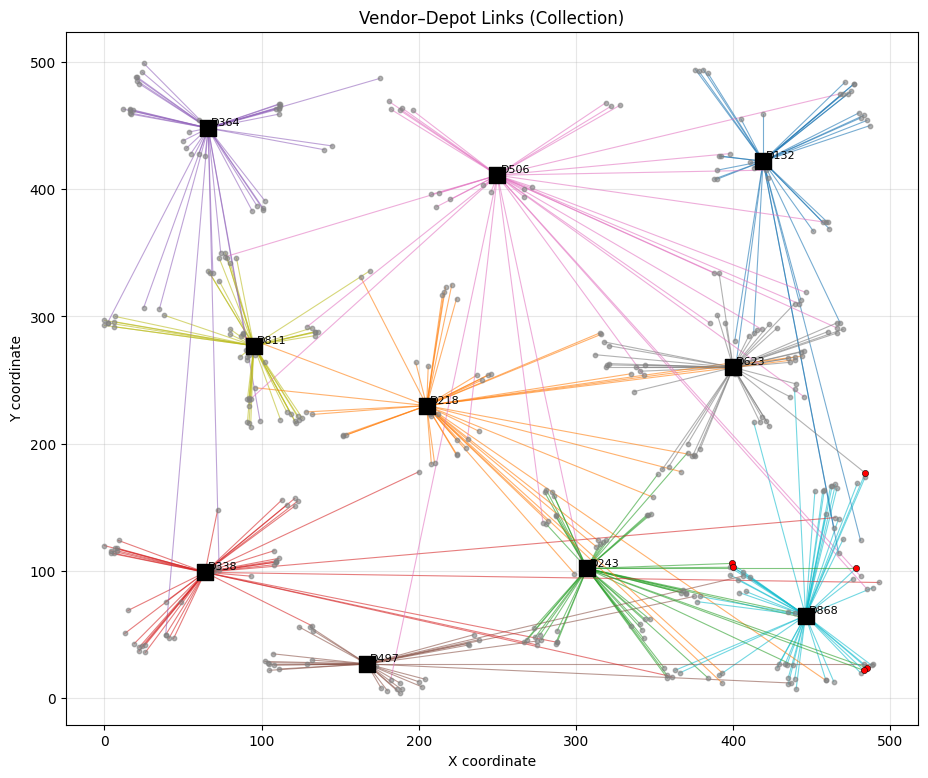


--- GIAI ĐOẠN 2: GÁN MARKETS TỪ DEPOTS (PHÂN PHỐI) ---
Assigning markets to nearest depots with available supply...
Depot supply summary (Remaining goods after serving markets):
Depot 132: 100.0% of collected goods were distributed.
Depot 218: 93.5% of collected goods were distributed.
Depot 243: 70.4% of collected goods were distributed.
Depot 338: 94.4% of collected goods were distributed.
Depot 364: 66.2% of collected goods were distributed.
Depot 497: 70.4% of collected goods were distributed.
Depot 506: 55.5% of collected goods were distributed.
Depot 623: 100.0% of collected goods were distributed.
Depot 811: 76.3% of collected goods were distributed.
Depot 868: 100.0% of collected goods were distributed.
Saved MARKET cluster file: C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_standard_market_cluster.json


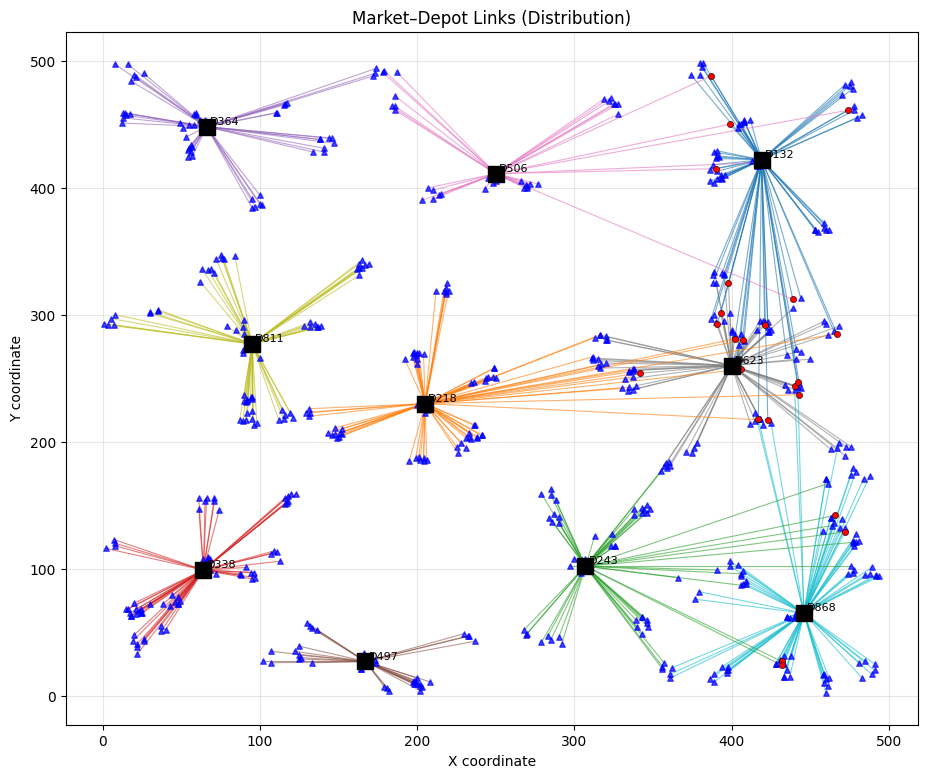

In [7]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt


def manhattan(a, b):
    return abs(a["coord_x"] - b["coord_x"]) + abs(a["coord_y"] - b["coord_y"])


def ensure_depot_capacity_dict(depots, commodities):
    for d in depots:
        if "storage_capacity_dict" not in d or not d["storage_capacity_dict"]:
            if "storage_capacity_vec" in d:
                d["storage_capacity_dict"] = {
                    c: float(v) for c, v in zip(commodities, d["storage_capacity_vec"])
                }
            else:
                d["storage_capacity_dict"] = {c: 0.0 for c in commodities}

# --- HÀM MỚI (ĐỂ SỬA LỖI) ---
def ensure_market_order_dict(markets, commodities):
    """
    Đảm bảo mỗi market node có một 'order_dict'.
    Hàm này kiểm tra 'order_dict' (đúng) và các tên dự phòng như 'demand_vec'.
    """
    for m in markets:
        # 1. Kiểm tra tên chính xác 'order_dict' trước
        if "order_dict" in m and m["order_dict"]:
            continue  # Đã có, không cần làm gì

        # 2. Kiểm tra dự phòng 'demand_dict' (tên tôi dùng sai)
        if "demand_dict" in m and m["demand_dict"]:
            m["order_dict"] = m.pop("demand_dict")  # Đổi tên nó
            continue

        # 3. Kiểm tra dự phòng 'demand_vec' (từ dữ liệu Li & Lim gốc)
        if "demand_vec" in m:
            m["order_dict"] = {
                c: float(v) for c, v in zip(commodities, m["demand_vec"])
            }
            continue
            
        # 4. Kiểm tra dự phòng 'demand' (nếu chỉ có 1 con số)
        if "demand" in m and isinstance(m["demand"], (int, float)):
             m["order_dict"] = {commodities[0]: float(m["demand"])}
             continue

        # 5. Nếu không có gì, giả sử nhu cầu là 0
        print(f"Warning: Market {m['id']} không có 'order_dict' hoặc 'demand_vec'. Đặt nhu cầu = 0.")
        m["order_dict"] = {c: 0.0 for c in commodities}


# --- GIAI ĐOẠN 1: GÁN VENDORS VÀO DEPOT (Thu gom) ---

def assign_vendors_two_phase(data, load_threshold=0.7):
    print("--- GIAI ĐOẠN 1: GÁN VENDORS VÀO DEPOTS (THU GOM) ---")
    commodities = data["meta"]["commodities"]
    K = len(commodities)
    depots = [n for n in data["nodes"] if n["type"] == "depot"]
    vendors = [n for n in data["nodes"] if n["type"] == "vendor"]

    if not depots:
        raise ValueError("No depot found.")
    if not vendors:
        print("Warning: No vendor found.")
        return {}, {}, depots, [], {d["id"]: np.zeros(K) for d in depots}

    ensure_depot_capacity_dict(depots, commodities)

    depot_remaining = {
        d["id"]: np.array([d["storage_capacity_dict"].get(c, 0.0) for c in commodities], dtype=float)
        for d in depots
    }
    depot_init = {d["id"]: depot_remaining[d["id"]].copy() for d in depots}
    depot_load = {d["id"]: np.zeros(K) for d in depots}

    # Sửa lỗi an toàn: dùng .get() phòng trường hợp vendor không có hàng
    vendors.sort(key=lambda v: sum(v.get("collected_goods_dict", {}).values()), reverse=True)

    print(f"Phase 1: Assign vendors with threshold {load_threshold*100:.0f}%")

    vendor_assignments = {}
    unassigned = []

    for v in vendors:
        v_id = v["id"]
        # Sửa lỗi an toàn: dùng .get()
        v_vec = np.array([v.get("collected_goods_dict", {}).get(c, 0.0) for c in commodities])
        remain = v_vec.copy()
        assigns = []

        for d in sorted(depots, key=lambda d: manhattan(v, d)):
            d_id = d["id"]
            current_load = depot_load[d_id] / np.maximum(depot_init[d_id], 1e-9)
            if np.max(current_load) >= load_threshold:
                continue
            cap = depot_remaining[d_id]
            take = np.minimum(remain, cap)
            if np.any(take > 1e-5):
                assigns.append({"depot_id": d_id, "assigned_vec": take})
                depot_remaining[d_id] -= take
                depot_load[d_id] += take
                remain -= take
            if np.all(remain <= 1e-5):
                break

        vendor_assignments[v_id] = assigns
        if np.any(remain > 1e-5):
            unassigned.append({"id": v_id, "remaining": remain})

    print("Phase 2: Continue assigning and split if overloaded")

    still_unassigned = []
    for v_log in unassigned:
        v_id = v_log["id"]
        remain = v_log["remaining"]
        assigns = vendor_assignments[v_id]
        v_node = next(v for v in vendors if v["id"] == v_id)

        for d in sorted(depots, key=lambda d: manhattan(v_node, d)):
            d_id = d["id"]
            cap = depot_remaining[d_id]
            take = np.minimum(remain, cap)
            if np.any(take > 1e-5):
                assigns.append({"depot_id": d_id, "assigned_vec": take})
                depot_remaining[d_id] -= take
                depot_load[d_id] += take
                remain -= take
            if np.all(remain <= 1e-5):
                break

        vendor_assignments[v_id] = assigns
        if np.any(remain > 1e-5):
            still_unassigned.append({"id": v_id, "remaining": remain})

    total_assigned_to_depots = {d["id"]: np.zeros(K) for d in depots}
    vendor_primary = {}

    for v_id, assigns in vendor_assignments.items():
        if not assigns:
            continue
        best_mass, best_d = -1, assigns[0]["depot_id"]
        for a in assigns:
            d_id = a["depot_id"]
            total_assigned_to_depots[d_id] += a["assigned_vec"]
            mass = np.sum(a["assigned_vec"])
            if mass > best_mass:
                best_mass, best_d = mass, d_id
        vendor_primary[v_id] = best_d

    print("Depot utilization summary (Storage Capacity):")
    for d in depots:
        d_id = d["id"]
        init = depot_init[d_id]
        used = total_assigned_to_depots[d_id]
        pct_vec = np.divide(used, init, out=np.zeros_like(init), where=init != 0) * 100
        print(f"Depot {d_id}: {np.max(pct_vec):.1f}% full.")

    return vendor_assignments, vendor_primary, depots, vendors, total_assigned_to_depots


# --- HÀM ĐÃ SỬA LỖI: GÁN MARKETS TỪ DEPOT (Phân phối) ---

def assign_markets_from_supply(data, depots, markets, vendor_total_assigned):
    """
    Gán markets vào depots dựa trên NGUỒN CUNG (supply) 
    mà các vendor đã mang đến.
    """
    print("\n--- GIAI ĐOẠN 2: GÁN MARKETS TỪ DEPOTS (PHÂN PHỐI) ---")
    commodities = data["meta"]["commodities"]
    
    if not markets:
        print("Warning: No market found.")
        return {}, []

    # *** THÊM BƯỚC NÀY ***
    # Đảm bảo tất cả market nodes đều có 'order_dict'
    ensure_market_order_dict(markets, commodities) # <--- GỌI HÀM SỬA LỖI

    # "Nguồn cung" của kho chính là lượng hàng vendor đã gán
    depot_remaining_supply = {
        d_id: vendor_total_assigned[d_id].copy() for d_id in vendor_total_assigned
    }
    
    # Sắp xếp markets theo nhu cầu (demand) giảm dần
    # *** SỬA TÊN KEY Ở ĐÂY ***
    markets.sort(key=lambda m: sum(m["order_dict"].values()), reverse=True) # <--- SỬA LỖI
    
    market_assignments = {}
    unsupplied_markets = []

    print("Assigning markets to nearest depots with available supply...")
    
    for m in markets:
        m_id = m["id"]
        # Market có "order_dict"
        # *** SỬA TÊN KEY Ở ĐÂY ***
        m_vec = np.array([m["order_dict"].get(c, 0.0) for c in commodities]) # <--- SỬA LỖI
        remain = m_vec.copy() # Nhu cầu còn lại
        assigns = []

        # Tìm depot gần nhất CÓ HÀNG
        for d in sorted(depots, key=lambda d: manhattan(m, d)):
            d_id = d["id"]
            
            supply = depot_remaining_supply[d_id] # Lượng cung còn lại của kho
            
            # Lượng hàng có thể lấy (take) là min(nhu cầu, nguồn cung)
            take = np.minimum(remain, supply)
            
            if np.any(take > 1e-5):
                assigns.append({"depot_id": d_id, "assigned_vec": take})
                depot_remaining_supply[d_id] -= take # Giảm nguồn cung kho
                remain -= take # Giảm nhu cầu market
                
            if np.all(remain <= 1e-5): # Nhu cầu đã được đáp ứng
                break
        
        market_assignments[m_id] = assigns
        if np.any(remain > 1e-5):
            unsupplied_markets.append({"id": m_id, "remaining": remain})

    # Báo cáo về nguồn cung còn lại
    print("Depot supply summary (Remaining goods after serving markets):")
    for d in depots:
        d_id = d["id"]
        init_supply = vendor_total_assigned[d_id]
        remain_supply = depot_remaining_supply[d_id]
        
        # % nguồn cung đã được sử dụng
        pct_used_vec = np.divide(
            (init_supply - remain_supply), 
            init_supply, 
            out=np.zeros_like(init_supply), 
            where=init_supply != 0
        ) * 100
        print(f"Depot {d_id}: {np.max(pct_used_vec):.1f}% of collected goods were distributed.")

    if unsupplied_markets:
        print("\nWARNING: Total vendor supply was INSUFFICIENT for market demand.")
        for m in unsupplied_markets:
            print(f"  Market {m['id']} still needs: {m['remaining']}")
            
    return market_assignments, unsupplied_markets


# --- HÀM LƯU FILE JSON (CHO VENDOR) ---

def save_vendor_cluster_json(out_path, depots, vendors, commodities, vendor_assignments):
    vendor_map = {v["id"]: v for v in vendors}
    K = len(commodities)
    
    clusters = []
    for d in depots:
        d_id = d["id"]
        assigned_vendors_demand = {}
        vendor_coordinates = {}
        total_assigned_vec = np.zeros(K)

        for v_id, assignments in vendor_assignments.items():
            for assign in assignments:
                if assign["depot_id"] == d_id:
                    demand_vec = assign["assigned_vec"]
                    if np.sum(demand_vec) <= 1e-5: continue
                    total_assigned_vec += demand_vec
                    assigned_vendors_demand[v_id] = [round(float(v), 3) for v in demand_vec]
                    if v_id not in vendor_coordinates:
                        v_node = vendor_map[v_id]
                        vendor_coordinates[v_id] = {
                            "coord_x": v_node["coord_x"],
                            "coord_y": v_node["coord_y"]
                        }

        total_assigned_dict = {
            c: round(float(v), 3) 
            for c, v in zip(commodities, total_assigned_vec)
        }

        clusters.append({
            "depot_node_id": d_id,
            "depot_coord_x": d["coord_x"],
            "depot_coord_y": d["coord_y"],
            "depot_storage_capacity": d.get("storage_capacity_dict", {}),
            "total_assigned_mass": total_assigned_dict,
            "assigned_vendors_demand": assigned_vendors_demand,
            "vendor_coordinates": vendor_coordinates
        })
        
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump({"clusters": clusters, "type": "vendor_collection"}, f, indent=2)
    print(f"Saved VENDOR cluster file: {out_path}")


# --- HÀM LƯU FILE JSON MỚI (CHO MARKET) ---

def save_market_cluster_json(out_path, depots, markets, commodities, market_assignments):
    market_map = {m["id"]: m for m in markets}
    K = len(commodities)
    
    clusters = []
    for d in depots:
        d_id = d["id"]
        
        assigned_markets_demand = {}
        market_coordinates = {}
        total_distributed_vec = np.zeros(K)

        for m_id, assignments in market_assignments.items():
            for assign in assignments:
                if assign["depot_id"] == d_id:
                    demand_vec = assign["assigned_vec"]
                    if np.sum(demand_vec) <= 1e-5: continue
                    total_distributed_vec += demand_vec
                    assigned_markets_demand[m_id] = [round(float(v), 3) for v in demand_vec]
                    if m_id not in market_coordinates:
                        m_node = market_map[m_id]
                        market_coordinates[m_id] = {
                            "coord_x": m_node["coord_x"],
                            "coord_y": m_node["coord_y"]
                        }

        total_distributed_dict = {
            c: round(float(v), 3) 
            for c, v in zip(commodities, total_distributed_vec)
        }

        clusters.append({
            "depot_node_id": d_id,
            "depot_coord_x": d["coord_x"],
            "depot_coord_y": d["coord_y"],
            "total_distributed_mass": total_distributed_dict,
            "assigned_markets_demand": assigned_markets_demand,
            "market_coordinates": market_coordinates
        })
        
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump({"clusters": clusters, "type": "market_distribution"}, f, indent=2)
    print(f"Saved MARKET cluster file: {out_path}")


# --- HÀM VẼ (CHO VENDOR) ---

def plot_vendor_depot_links(depots, vendors, vendor_assignments, highlight_split=True, title="Vendor–Depot Links (Collection)"):
    if not vendors: return
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(depots))))
    color_map = {d["id"]: colors[i % 10] for i, d in enumerate(depots)}

    plt.figure(figsize=(11, 9))

    for v in vendors:
        v_id = v["id"]
        if v_id not in vendor_assignments: continue
        assigns = vendor_assignments[v_id]
        for assign in assigns:
            d_id = assign["depot_id"]
            d = next(d for d in depots if d["id"] == d_id)
            plt.plot(
                [v["coord_x"], d["coord_x"]], [v["coord_y"], d["coord_y"]],
                color=color_map[d_id], linewidth=0.8, alpha=0.6
            )

    for v in vendors:
        v_id = v["id"]
        n_assign = len(vendor_assignments.get(v_id, []))
        if highlight_split and n_assign > 1:
            plt.scatter(v["coord_x"], v["coord_y"], s=20, c="red", edgecolors="black", linewidths=0.4, zorder=3)
        else:
            plt.scatter(v["coord_x"], v["coord_y"], s=10, c="gray", marker="o", alpha=0.6, zorder=2) 

    for d in depots:
        plt.scatter(d["coord_x"], d["coord_y"], s=130, c="black", marker="s", zorder=4)
        plt.text(d["coord_x"] + 2, d["coord_y"] + 2, f"D{d['id']}", fontsize=8)

    plt.title(title)
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(alpha=0.3)
    plt.show()


# --- HÀM VẼ MỚI (CHO MARKET) ---

def plot_market_depot_links(depots, markets, market_assignments, highlight_split=True, title="Market–Depot Links (Distribution)"):
    if not markets: return
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(depots))))
    color_map = {d["id"]: colors[i % 10] for i, d in enumerate(depots)}

    plt.figure(figsize=(11, 9))

    for m in markets:
        m_id = m["id"]
        if m_id not in market_assignments: continue
        assigns = market_assignments[m_id]
        for assign in assigns:
            d_id = assign["depot_id"]
            d = next(d for d in depots if d["id"] == d_id)
            plt.plot(
                [m["coord_x"], d["coord_x"]], [m["coord_y"], d["coord_y"]],
                color=color_map[d_id], linewidth=0.8, alpha=0.6
            )

    for m in markets:
        m_id = m["id"]
        n_assign = len(market_assignments.get(m_id, []))
        if highlight_split and n_assign > 1:
            plt.scatter(m["coord_x"], m["coord_y"], s=20, c="red", edgecolors="black", linewidths=0.4, zorder=3)
        else:
            plt.scatter(m["coord_x"], m["coord_y"], s=15, c="blue", marker="^", alpha=0.7, zorder=2)

    for d in depots:
        plt.scatter(d["coord_x"], d["coord_y"], s=130, c="black", marker="s", zorder=4)
        plt.text(d["coord_x"] + 2, d["coord_y"] + 2, f"D{d['id']}", fontsize=8)

    plt.title(title)
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(alpha=0.3)
    plt.show()


# --- HÀM MAIN (CHÍNH) ---

if __name__ == "__main__":
    # Tự động lấy đường dẫn file (an toàn hơn)
    # Vui lòng đặt file JSON trong cùng thư mục với script
    # hoặc cung cấp đường dẫn đầy đủ
    try:
        # Giả sử file JSON nằm cùng thư mục với script
        script_dir = os.path.dirname(__file__)
        INPUT_JSON = os.path.join(script_dir, "LC1_10_1_standard.json")
        # Kiểm tra xem file có tồn tại không
        if not os.path.exists(INPUT_JSON):
             raise FileNotFoundError
    except (FileNotFoundError, NameError):
        # Nếu không tìm thấy, quay lại đường dẫn tuyệt đối bạn đã cung cấp
        print("Không tìm thấy file JSON trong thư mục script, sử dụng đường dẫn tuyệt đối...")
        INPUT_JSON = r"C:\Users\thaip\Desktop\VRP4\data\JSON\Li_Lim_1000_instances\LC1_10_1_standard.json" # <--- SỬA LẠI ĐƯỜNG DẪN NÀY NẾU CẦN

    BASE_OUTPUT_NAME = os.path.splitext(INPUT_JSON)[0]

    with open(INPUT_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    commodities = data["meta"]["commodities"]

    # --- CHẠY GIAI ĐOẠN 1 (VENDORS) ---
    (
        vendor_assignments, 
        primary_map, 
        depots, 
        vendors, 
        total_assigned_to_depots
    ) = assign_vendors_two_phase(data, load_threshold=0.7)

    VENDOR_CLUSTER_JSON = BASE_OUTPUT_NAME + "_vendor_cluster.json"
    save_vendor_cluster_json(
        VENDOR_CLUSTER_JSON, 
        depots, 
        vendors, 
        commodities, 
        vendor_assignments
    )
    plot_vendor_depot_links(depots, vendors, vendor_assignments)


    # --- CHẠY GIAI ĐOẠN 2 (MARKETS) ---
    markets = [n for n in data["nodes"] if n["type"] == "market"]
    
    (
        market_assignments, 
        unsupplied_markets
    ) = assign_markets_from_supply(
        data, 
        depots, 
        markets, 
        total_assigned_to_depots
    )
    
    MARKET_CLUSTER_JSON = BASE_OUTPUT_NAME + "_market_cluster.json"
    save_market_cluster_json(
        MARKET_CLUSTER_JSON, 
        depots, 
        markets, 
        commodities, 
        market_assignments
    )
    plot_market_depot_links(depots, markets, market_assignments)